In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

import pickle 

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

from torch_geometric.nn import SGConv, GCNConv
from torch_geometric.data import Data

### Preprocessing RNA and Tn datasets
!!!: RNA data metadata cols don't match Tn data metadata cols

Don't need them to match exactly, but would prefer the same metadata for each modality

In [21]:
with open('2_PreprocessedData_RbTnSeq.pickle', 'rb') as handle:
    tn = pickle.load(handle)  

with open('2_PreprocessedData_RNASeq_OD.pickle', 'rb') as handle:
    rna = pickle.load(handle)  

Put the data in AnnData format

In [22]:
rna['X'] = rna['X'].T
rna['X'].index = rna['X'].index.astype(str)
rna['metadata'].index = rna['metadata'].index.astype(str)
rna['metadata'].reset_index(inplace=True,drop=True)

rnadata = sc.AnnData(rna['X'])
rnadata.obs = rna['metadata']

In [23]:
tn['X'] = tn['X'].T
tn['X'].index = tn['X'].index.astype(str)
tn['metadata'].index = tn['metadata'].index.astype(str)

tndata = sc.AnnData(tn['X'])
tndata.obs = tn['metadata']

Subset the genes to those in common between RNA and Tn

In [24]:
genes_in_common = list(set(rnadata.var_names).intersection(set(tndata.var_names)) )

# SUBSET TO ONLY 250 GENES TO MAKE MODEL SETUP EASIER
np.random.seed(42)

random_genes = np.random.choice(range(len(genes_in_common)), 250, replace=False)
genes_in_common = [genes_in_common[ii] for ii in random_genes]

rnadata = rnadata[:,genes_in_common].copy()
tndata = tndata[:,genes_in_common].copy()

### Sample QC

### Gene QC

### Sample and Gene Filtering

### Batch effect removal 

In [6]:
# sc.pp.combat(tndata, key='BioReplicate', covariates=['condition','TimePoint'], inplace=True)

### Weighted Gene Co-expression Network 
Question: How should we incorporate multiple experimental conditions? Separate graphs for each? 

We define the adjacency matrix as:

$A_{ij} = \mathrm{corr}(g_i,g_j)^\beta $

Here $\beta$ is a soft thresholding parameter to transform the Pearson correlations between gene $i$ and gene $j$ into a directed edge. 

Note that by construction, $A$ already contains self-loops. Don't add another self-loop during training, a typical procedure when training graph convolutional networks.

In [325]:
beta = 5

cor = np.corrcoef(rnadata[rnadata.obs.condition.isin(['NC'])].X.T)
A = cor ** beta
A[np.abs(A) <= 10e-4] = 0.0 


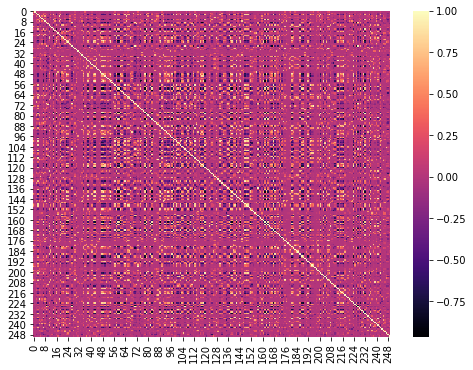

In [327]:
plt.figure(figsize=(8,6))
sns.heatmap(A,cmap='magma')
plt.show()

### Graph edges: `data.edge_index` of shape `[2, num_edges]`


In [335]:
adj = torch.tensor(A,dtype=torch.float32)
edge_index = adj.nonzero().t().contiguous()
edge_index.shape

torch.Size([2, 46240])

In [336]:
edge_index

tensor([[  0,   0,   0,  ..., 249, 249, 249],
        [  0,   1,   3,  ..., 246, 248, 249]])

### Graph edge weights: `data.edge_weight` of shape `[num_edges]` ?
we'll find out if this shape is a problem later

In [337]:
row1, row2 = edge_index
edge_weight = adj[row1, row2]

### Node feature matrix: `data.x` of shape  `[num_nodes x num_node_features]`
Using condition `NC` at the moment. Still thinking of how to incorporate all the conditions into the node prediction task. What would be useful? 

In [338]:
x = torch.tensor(tndata[tndata.obs.condition.isin(['NC'])].X.copy().T)
x_train = x[:,0:7] # BioReplicate 1
x_test = x[:,7:] # BioReplicate 2

### Graph data class

In [339]:
# data = Data(x=x_train, edge_index=edge_index, num_nodes=len(x), edge_weight=edge_weight)
data = Data(x=x, edge_index=edge_index, num_nodes=len(x), edge_weight=edge_weight)

### Node targets: `data.y`
As of now, the targets are one-hots corresponding to which gene was knocked down. Though there may be some other more reasonable approach for formulating the targets

In [340]:
a = np.array([ii for ii in range(len(x))])
y = np.zeros((a.size, a.max() + 1))
y[np.arange(a.size), a] = 1
# y = np.arange(0,data.num_nodes)/(data.num_nodes-1)

In [341]:
data.y = torch.tensor(y,dtype=torch.float32)

### Model architecture

In [346]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        num_classes = data.num_nodes
#         num_classes = 1
        self.conv1 = SGConv(data.num_features, num_classes, K=2, add_self_loops=False, 
                            edge_weight=data.edge_weight,cached=False) # cached->what does this do, how does it relate to semi-supervision?

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index, edge_weight)
        
        return x

In [350]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)

torch.manual_seed(0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.025, weight_decay=0.05)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.15, momentum=0.0, dampening=0.0, weight_decay=0.0)
scheduler = ExponentialLR(optimizer, gamma=0.95)
# criterion = nn.CrossEntropyLoss() # computes softmax and then the cross entropy
# criterion = nn.MSELoss()
# criterion = nn.KLDivLoss()

### Model training

NEED TO CHECK THAT THE DIMENSIONS OF THE DATA GOING IN ARE CORRECT WITH WHICHEVER WAY PYTORCH IS DOING MATMUL

Epoch: 001, Train: 0.0040
Epoch: 002, Train: 0.0040
Epoch: 003, Train: 0.0040
Epoch: 004, Train: 0.0040
Epoch: 005, Train: 0.0040
Epoch: 006, Train: 0.0040
Epoch: 007, Train: 0.0040
Epoch: 008, Train: 0.0040
Epoch: 009, Train: 0.0040
Epoch: 010, Train: 0.0040
Epoch: 011, Train: 0.0040
Epoch: 012, Train: 0.0040
Epoch: 013, Train: 0.0040
Epoch: 014, Train: 0.0040
Epoch: 015, Train: 0.0040
Epoch: 016, Train: 0.0040
Epoch: 017, Train: 0.0040
Epoch: 018, Train: 0.0040
Epoch: 019, Train: 0.0040
Epoch: 020, Train: 0.0040
Epoch: 021, Train: 0.0040
Epoch: 022, Train: 0.0040
Epoch: 023, Train: 0.0040
Epoch: 024, Train: 0.0040
Epoch: 025, Train: 0.0040
Epoch: 026, Train: 0.0040
Epoch: 027, Train: 0.0040
Epoch: 028, Train: 0.0040
Epoch: 029, Train: 0.0040
Epoch: 030, Train: 0.0040
Epoch: 031, Train: 0.0040
Epoch: 032, Train: 0.0040
Epoch: 033, Train: 0.0040
Epoch: 034, Train: 0.0040
Epoch: 035, Train: 0.0040
Epoch: 036, Train: 0.0040
Epoch: 037, Train: 0.0040
Epoch: 038, Train: 0.0040
Epoch: 039, 

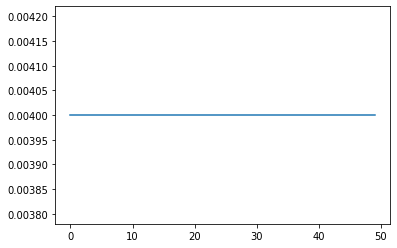

In [351]:
train_acc = []
for ii, epoch in enumerate(range(1, 51)):
    model.train(True) # for gradient tracking 
    
    optimizer.zero_grad()
    yhat = model()
    loss = criterion(torch.transpose(yhat,0,1), data.y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    model.train(False) # don't need to track gradients for metrics
#     acc = np.linalg.norm(yhat.detach() - y)
#     train_acc.append(acc)
    corrects = (yhat.argmax(dim=0) == data.y.argmax(dim=0))
    train_acc.append( (corrects.sum()/data.y.size(1)).item() )
    print(f'Epoch: {epoch:03d}, Train: {train_acc[ii]:.4f}')
    
plt.plot(train_acc)

In [293]:
np.where((yhat.argmax(dim=0) - data.y.argmax(dim=0)).detach() == 0)

(array([0]),)

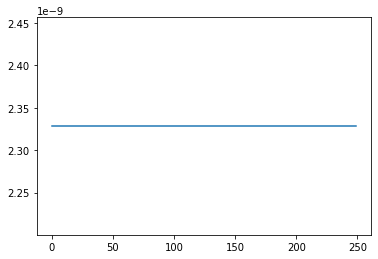

In [295]:
plt.plot(yhat.detach()[:,0])

1


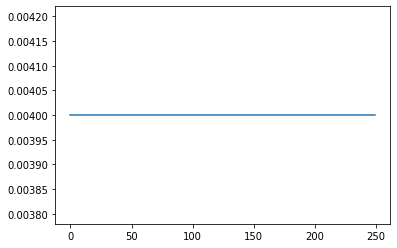

In [297]:
print(corrects.sum().item())
plt.plot(nn.functional.softmax(yhat[0,:],dim=0).detach().numpy())
plt.show()

### Model evaluation

In [83]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0022, -0.0032, -0.0020,  ..., -0.0028, -0.0016, -0.0026],
         [ 0.0038,  0.0063,  0.0061,  ...,  0.0073,  0.0069,  0.0077],
         [-0.0011, -0.0021, -0.0030,  ..., -0.0028, -0.0019, -0.0009],
         ...,
         [-0.0034, -0.0036, -0.0015,  ..., -0.0021, -0.0021, -0.0025],
         [-0.0014, -0.0026, -0.0028,  ..., -0.0033, -0.0027, -0.0042],
         [-0.0006, -0.0027, -0.0002,  ..., -0.0021, -0.0006, -0.0017]],
        requires_grad=True),
 Parameter containing:
 tensor([-9.3830e-04,  1.4449e-04,  1.0668e-03, -1.7814e-03, -6.7264e-04,
         -7.1423e-04, -7.9271e-04,  7.5173e-04,  1.3151e-03,  3.8234e-04,
          2.2107e-04,  3.1005e-04, -4.3021e-04,  1.3550e-04, -7.4482e-04,
          1.2317e-03,  1.1400e-03, -7.1479e-04, -1.6300e-04, -1.5588e-04,
          5.2634e-04,  2.1906e-04, -1.0933e-04,  1.1681e-03,  3.1861e-04,
          3.0522e-04,  2.0317e-03,  1.1208e-03, -3.7938e-04, -3.6237e-04,
         -5.0126e-04, -1.1069e-03, -5.95

In [ ]:
def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

### GCNConv

In [284]:
# GCN model with 3 layers 
class Net(torch.nn.Module):
    def __init__(self, n_hidden):
        super(Net, self).__init__()
        num_classes = data.num_nodes
        self.conv1 = GCNConv(data.num_features, n_hidden, add_self_loops=False)
        self.conv2 = GCNConv(n_hidden, n_hidden, add_self_loops=False)
        self.conv3 = GCNConv(n_hidden, int(num_classes), add_self_loops=False)
        # How to include edge weights? 
        
    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = nn.functional.relu(self.conv1(x, edge_index))
        x = nn.functional.dropout(x, training=self.training)
        x = nn.functional.relu(self.conv2(x, edge_index))
        x = nn.functional.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [285]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_hidden = 250
model, data = Net(num_hidden).to(device), data.to(device)

torch.manual_seed(42)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0075, weight_decay=0.05)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.1, dampening=0, weight_decay=0.05)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss() # computes softmax and then the cross entropy

Epoch: 010, Train: 0.0080
Epoch: 020, Train: 0.0120
Epoch: 030, Train: 0.0080
Epoch: 040, Train: 0.0040
Epoch: 050, Train: 0.0040
Epoch: 060, Train: 0.0040
Epoch: 070, Train: 0.0080
Epoch: 080, Train: 0.0120
Epoch: 090, Train: 0.0040
Epoch: 100, Train: 0.0080


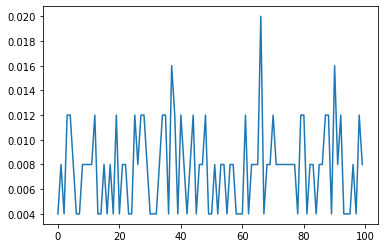

In [286]:
train_acc = []
for ii, epoch in enumerate(range(1, 101)):
    model.train(True) # for gradient tracking 
    
    optimizer.zero_grad()
    yhat = model()
    loss = criterion(yhat, data.y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    model.train(False) # don't need to track gradients for metrics
    corrects = (yhat.argmax(dim=0) == data.y.argmax(dim=0))
    train_acc.append( (corrects.sum()/data.y.size(1)).item() )
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch:03d}, Train: {train_acc[ii]:.4f}')
    
plt.plot(train_acc)


In [120]:
corrects.sum()

tensor(1)

### Logistic Regression on fitness data to classify gene knockdown

In [221]:
from sklearn.linear_model import LogisticRegression

In [222]:
y = np.arange(0,data.num_nodes)

In [223]:
lr = LogisticRegression(multi_class='multinomial',C=10)
lr = lr.fit(data.x.numpy(), y)
# y_pred = lr_iris.predict(X)

In [224]:
lr.predict(data.x.numpy())

array([  0,  46,  56, 213,  22,   5, 173,  36,   8,   9,  10, 197,  12,
        82,  14,  82, 191, 137, 173,  19, 177, 169,  22, 244,  24, 158,
       219,  27,  63, 185,  12, 233,  97,  33, 148,  97,  36, 213,  63,
         5, 249,  41,  30,  12,  44, 180,  46, 146, 121, 197, 219,  51,
        52, 173, 108, 162,  56,  57, 185,  85,  60,  12,  10,  63,  64,
        24, 155,  67,  71, 235,  70,  82,  72,   9, 110,  75, 108,  77,
       190,  93,  80, 110,  82,  83,  92,  72,  86, 148,  88, 110,  90,
       173,  92,  93, 117, 151,  96,  97,  98, 231, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 110, 110, 113, 240,  46,   4,
       117, 248,   9, 120, 121, 122, 123, 124, 108,  80, 127, 128, 129,
       130, 108, 139, 233, 246, 213, 136, 137, 138,  82, 173, 141, 157,
       177, 246,  98, 146, 216, 148, 110,  70, 151, 152, 110, 117,   5,
        82, 157, 173, 159, 185,  92, 185, 163, 164, 165,  98, 219,   8,
       169,  97, 171, 175, 173, 233, 175, 219, 177, 173, 179, 18

In [225]:
lr.coef_.shape

(250, 7)

In [226]:
data.x.numpy().shape

(250, 7)

In [230]:
len(np.where(lr.predict(data.x.numpy()) - y==0)[0])/250

0.44

In [231]:
len(np.where(lr.predict(x_test) - y==0)[0])/250

0.016